# Elliptical axon simulation using PyMunk

# Importing

In [2]:
import pygame                                   # Display
import pymunk                                   # Physics engine
import random
import matplotlib.pyplot as plt
import copy
import numpy as np
from math import prod
from scipy.spatial import ConvexHull, Delaunay
import pandas as pd
import matplotlib.colors
import scipy.interpolate
from sklearn.linear_model import LinearRegression
from scipy import stats

pygame 2.5.2 (SDL 2.28.3, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Initialization and set-up

In [3]:
W, H = (2000, 2000)                               # Set length and width of display
dt = 0.1                                       # Frames per second to update screen
T = 1000                                       # total simulation time
bbox_size = 2000
bbox = int((W-bbox_size)/2 - 1), int((H-bbox_size)/2 - 1)
gravityStrength = 1.0e-1
random.seed(2)

### Helper functions

In [4]:
# This is necessary because were using pygame to display the simulation and pygame needs integer coordinates with opposite y-axis to pymunk
def convert_coords(point):
    return (int(point[0]), int(H - point[1]))

# Linear 'gravitaional' attraction to the center of the domain
def gravity_func(body, gravity, damping, dt):
    g = (
        (body.position - pymunk.Vec2d(W/2, H/2)) * -gravityStrength
        )
    pymunk.Body.update_velocity(body, g, .99, dt)

# Produces ellipse with n vertices 
def ellipse_vts(a, b):
    n = 50
    points = []
    for i in range(0, n+1):
        Theta = np.pi/2 * i /  n
        Fi =  np.pi/2 - np.arctan(np.tan(Theta) * a/b)
        x = round(a * np.cos(Fi))
        y = round(b * np.sin(Fi))
        points.extend([(x,y), (-x, y), (x, -y), (-x, -y)])
    return list(set(points))

# Makes mask of convex hull
def poly2mask(hull):
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    x, y = np.meshgrid(np.arange(W), np.arange(H))
    x, y = x.flatten(), y.flatten()
    pts = np.vstack((y, x)).T
    bool_img = hull.find_simplex(pts) >= 0
    bool_img = bool_img.reshape((W, H)) * 1
    return bool_img

# Object creation

In [5]:
class Axon_ellipse():
    def __init__(self, x0, y0, a, b, g_rat, space):
        vts = ellipse_vts(a, b)
        self.n_vts = len(vts)
        self.body = pymunk.Body()
        self.body.position = x0, y0
        self.shape = pymunk.Poly(self.body, vts, radius=0)
        self.shape.density = 1
        self.shape.elasticity = 0.25
        self.shape.friction = 0.75
        self.body.velocity_func = gravity_func
        self.body.angle = random.uniform(0, 2 * np.pi)
        self.g_rat = g_rat
        space.add(self.body, self.shape)

    def draw(self, display):
        vts = []
        vts_s = []
        v_list = self.shape.get_vertices()
        for i in range(len(v_list)-1):
            if i == 0:
                v_temp = v_list[-1] - v_list[1]
                v_temp = v_temp.perpendicular_normal()
                v_s = v_list[i] - v_temp * self.g_rat
            elif i == self.n_vts:
                v_temp = v_list[-2] - v_list[0]
                v_temp = v_temp.perpendicular_normal()
                v_s = v_list[i] - v_temp * self.g_rat
            else:
                v_temp = v_list[i-1] - v_list[i+1]
                v_temp = v_temp.perpendicular_normal()
                v_s = v_list[i] - v_temp * self.g_rat
            xv_s, yv_s = v_s.rotated(self.body.angle)
            xv, yv = v_list[i].rotated(self.body.angle)
            posn = self.body.position
            xv, yv = convert_coords((xv, yv) + posn)
            xv_s, yv_s = convert_coords((xv_s, yv_s) + posn)
            vts.append((xv, yv))
            vts_s.append((xv_s, yv_s))
        pygame.draw.polygon(display, (255, 255, 255), vts)
        pygame.draw.polygon(display, (128, 128, 128), vts_s)
        return vts

# Simulation function

In [6]:
def ellipse_sim(N, a, aspect, g_rat):   
    vts = []
    pygame.init()                                   
    space = pymunk.Space()                          
    axon_list = []
    display = pygame.display.set_mode((W, H))      
    for axon in range(N):
        rand = [random.uniform(0.1, 0.9) for i in range(2)]
        axon_list.append(Axon_ellipse(rand[0] * W, rand[1] * H , a , a * aspect , a * g_rat, space))
    for t in range(T):                                  
        for event in pygame.event.get():     
            if event.type == pygame.QUIT:
                return    
        if t == T - 1:
            display.fill((0, 0, 0))    
            for axon in axon_list:
                vts_n = axon.draw(display)
                vts.append(vts_n)
            pygame.display.update()
            image = copy.deepcopy(pygame.surfarray.pixels2d(display))  #[bbox[0]:bbox[0] + bbox_size, bbox[1]:bbox[1] + bbox_size])
            return image, np.concatenate(np.array(vts))
        space.step(dt)

NameError: name 'grats' is not defined

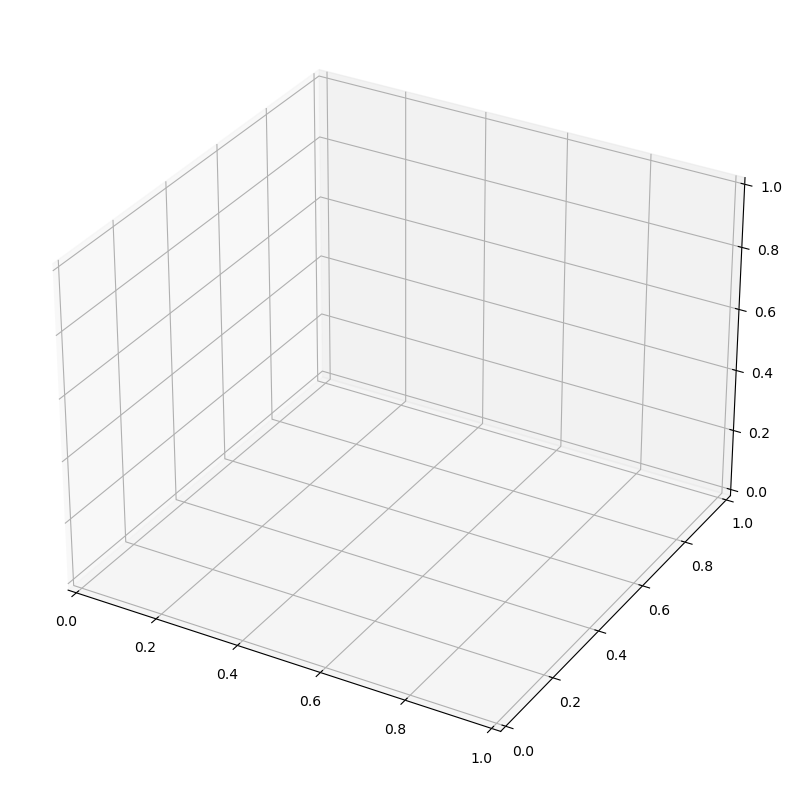

In [7]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(grats,eccs, MVF,
                 linewidth=0, antialiased=True, shade = True, alpha = .85, color ='red')
ax.set_xlabel('g ratio')
ax.set_ylabel('Aspect ratio')
ax.set_zlabel('MVF')
ax.view_init(45, 90)

### Data loading and processing

In [ ]:
data = pd.read_excel('data_extra_columns.xlsx')
'''
data.drop(data[data.gratio_peri > 1].index, inplace=True)
data.drop(data[(data.axon_diam_peri < 0.5) | (data.axon_diam_peri > 8)].index, inplace=True) # removing cells that are too small or big
''';

In [ ]:
'''data['ar'] = np.sqrt((1 - (data.eccentricity ** 2)))
''';

In [ ]:
'''mbp_per = {1: 160, 2: 100, 3: 58, 4: 63, 5: 63, 6: 28, 7: 15}
data['mbp'] = pd.Series([mbp_per[x] for x in data.line_num], index=data.index)
'''

In [ ]:
'''# Interpolate surface generated with algorithm above in order to obtain MVF measure for data
data['mvf'] = scipy.interpolate.griddata((grats.flatten(), eccs.flatten()), MVF.flatten(), (data.gratio_peri_2, data.ar), method='cubic')
''';

In [ ]:
'''data['cost'] = cost_fun(data.axon_diam_peri, data.gratio_peri_2, data.line)
data.fillna(data.mean(), inplace=True)  # Drop NaNs
''';

In [ ]:
data['mvf_bins'] = pd.cut(data.mvf, np.arange(0.15,0.75,0.05))

In [ ]:
data

In [ ]:
matplotlib.pyplot.close('all')

In [ ]:
data.to_excel('data_extra_columns.xlsx')

In [ ]:
plt.scatter(data[(data.line == 'M3M5KO') & (data.age == 'P30') & (data.region == 'CST')].gratio_peri_2, data[(data.line == 'M3M5KO') & (data.age == 'P30') & (data.region == 'CST')].mvf, label='P30')
plt.show()

In [ ]:
plt.scatter(data[(data.line == 'M3M5KO') & (data.age == 'P90') & (data.region == 'CST')].gratio_peri_2, data[(data.line == 'M3M5KO') & (data.age == 'P90') & (data.region == 'CST')].mvf, label='P90')
plt.legend()
plt.show()


In [ ]:
plt.legend()

In [ ]:
plt.scatter(data[(data.line == 'M3M5KO') & (data.age == 'P400') & (data.region == 'CST')].gratio_peri_2, data[(data.line == 'M3M5KO') & (data.age == 'P400') & (data.region == 'CST')].mvf)

In [ ]:
data[data.age == 'P400'].line

### Plotting MVF

In [ ]:
colormap = plt.get_cmap("plasma")
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.6)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

In [ ]:
print((np.mean(data.gratio_peri_2[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P30')]),
np.mean(data.ar[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P30')])))
print((np.mean(data.gratio_peri_2[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P90')]),
np.mean(data.ar[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P90')])))
(np.mean(data.gratio_peri_2[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P400')]),
np.mean(data.ar[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P400')]))

In [ ]:
X, Y = np.mgrid[0.65:0.9:100j, 0.3:0.9:100j]

positions = np.vstack([X.ravel(), Y.ravel()])

values1 = np.vstack([data.gratio_peri_2[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P30')],
                    data.ar[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P30')]])
values2 = np.vstack([data.gratio_peri_2[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P90')],
                     data.ar[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P90')]])
values3 = np.vstack([data.gratio_peri_2[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P400')],
                     data.ar[(data.gratio_peri_2 > 0.65) & (data.region == 'VM') & (data.line == 'M3M5KO') & (data.age == 'P400')]])

kernel1 = stats.gaussian_kde(values1)
kernel2 = stats.gaussian_kde(values2)
kernel3 = stats.gaussian_kde(values3)

Z1 = np.reshape(kernel1(positions).T, X.shape)
Z2 = np.reshape(kernel2(positions).T, X.shape)
Z3 = np.reshape(kernel3(positions).T, X.shape)


fig_cont = plt.figure(figsize = (25,10))

plt.rcParams['font.size'] = '18'
cont1 = plt.contour(grats,eccs, MVF, np.arange(0,0.65,0.05), linewidths = 5,cmap='plasma')
#plt.colorbar(shrink = 0.4, aspect = 15, label='MAF', pad = 0.02)
#scat2 = plt.scatter(data.gratio_peri_2[(data.gratio_peri_2 > 0.65) & (data.region == 'Gracilis') & (data.line == 'WT')], 
#                    data.ar[(data.gratio_peri_2 > 0.65) & (data.region == 'Gracilis') & (data.line == 'WT')], 
#                    c=colormap(norm(data.mbp[(data.gratio_peri_2 > 0.65) & (data.region == 'Gracilis') & (data.line == 'WT')]), alpha=1))


plt.imshow(np.rot90(Z1), cmap=plt.cm.Blues, extent=[0.65, 0.9, 0.3, 0.9], aspect=0.4, alpha=0)
#cbar2 = plt.colorbar( shrink = 0.4, aspect = 15, label='Density (wildtype)', pad =-0.08) 

#plt.imshow(np.rot90(Z2), cmap=plt.cm.Greens, extent=[0.65, 0.9, 0.3, 0.9], aspect=0.4, alpha=0.1)

#plt.imshow(np.rot90(Z2), cmap=plt.cm.Reds, extent=[0.65, 0.9, 0.3, 0.9], aspect=0.4, alpha=0.1)

plt.text(0.8429922283851089, 0.5901422791297479,'P90',weight='bold')
plt.text(0.850796180220818, 0.6058353854090531,'P30',weight='bold')
plt.text(0.8188459926313248, 0.5271609619619261,'P400',weight='bold')
         

plt.xlim((0.65, 0.9))
plt.ylim((0.3, 0.9))
cbar = plt.colorbar(sm, shrink = 0.4, aspect = 15, label='MAF', pad =0.01)
cbar2.set_ticks((0,8.625,17.25))
cbar2.ax.set_yticklabels(['0','0.5', '1'])
plt.xlabel('g ratio', fontsize = 18)
plt.ylabel('Aspect ratio', fontsize = 18)
plt.tight_layout()
plt.savefig('test.png')

In [ ]:
test_agg = data[(data.gratio_peri_2 > 0.65) & ~data.mvf_bins.isna()].groupby("line").agg([np.mean, stats.sem])
test_agg = test_agg.mvf

In [ ]:
data[(data.line.isin(('WT', 'M3KO', 'M5KO','M3M5KO','M1EM3M5KO'))) & (data.region == 'VM')].groupby(['line','mvf_bins']).n.count().unstack('mvf_bins').plot.bar(stacked = True, figsize=(10,8), rot = 35)
plt.legend(ncol=5,prop={'size': 10})
plt.xlabel('Line')
plt.ylabel('Count')
plt.ylim(0,1800)
plt.show()


In [ ]:
data2

In [ ]:
plt.figure(figsize=(20,10))
data2 = data.groupby(['line','mvf_bins']).size()
data2.pivot_table(index = 'line', columns = 'mvf_bins' , values = 'counts').plot(kind = 'bar', stacked = True)

In [ ]:
test_agg[test_agg.index.isin(('WT', 'M3KO', 'M5KO','M3M5KO','M1EM3M5KO'))].plot(kind='bar', y = 'mean', yerr = 'sem', legend=False,capsize=5,rot=35)
plt.xlabel('Line')
plt.ylabel('Average MAF')
plt.ticklabels(('100','63','63','28','15'))

In [ ]:
temp_agg = data[(data.gratio_peri_2 > 0.65) & (data.region == 'CST') & ~data.mvf_bins.isna()].groupby("mbp").agg([np.mean, stats.sem])
temp_agg = temp_agg.cost

In [ ]:
compare_plot = pd.read_csv('plot_data.csv')

In [ ]:
key

In [ ]:
test_agg = test_agg.iloc[key.argsort()]

In [ ]:
lines = ['WT','M3KO', 'M5KO', 'M3M5KO', 'M1EM3M5KO']
mapping = {ln: i for i, ln in enumerate(lines)}
key = test_agg.index.map(mapping)

In [ ]:
compare_plot.iloc[key.argsort()].plot(kind='bar', y = 'mean', yerr = 'sem', legend=False, rot = 0, capsize=3)
plt.xlabel('Mouse line')
plt.ylabel('MAF (% wildtype)')
ax = plt.gca()
ax.spines[["right", "top"]].set_visible(False)
plt.legend(["Data", "Simulation"])

In [ ]:
err_plot = temp_agg.plot(kind='bar', y = 'mean', yerr = 'sem', legend=False, rot = 0)
err_plot.set_xlabel('% MBP')
err_plot.set_ylabel('Cost (ATP)')
err_plot.set_ylim(0,4e7)

In [ ]:
# Histogram of MVF values
plt.hist(MVF.flatten(), np.arange(0,0.75,0.05))
plt.xlabel('MVF')
plt.show()

In [ ]:
# Scatter plot of g ratio / size / eccentricity and MVF
size_norm = data[(data.gratio_peri_2 > 0.65) & (data.region == 'CST')].axon_diam_peri / np.linalg.norm(data[(data.gratio_peri_2 > 0.65) & (data.region == 'CST')].axon_diam_peri) * 600
scatp = data[(data.gratio_peri_2 > 0.65) & (data.region == 'CST')].plot.scatter(x = 'mvf', y = 'cost', 
                                                                                c = colormap(norm(data.mbp[(data.gratio_peri_2 > 0.65) & (data.region == 'CST')])), 
                                                                                s = size_norm,
                                                                                grid = False, xlim=(0.09,0.75), ylim = (2e6, 2e8),
                                                                                alpha=0.75,
                                                                                logy = True)
scatp.set_xlabel('MVF')
scatp.set_ylabel('Cost (ATP)')
cbar = plt.colorbar(sm, shrink = 0.4, aspect = 15, label='% MBP', pad = 0.05)

In [ ]:
data_nonan = data.copy()

In [ ]:
data_nonan.dropna(inplace=True)
model_cost_mvf = LinearRegression(fit_intercept=True)
model_cost_mvf.fit(data_nonan[(data_nonan.gratio_peri_2 > 0.65) & (data_nonan.region == 'CST')].mvf.to_numpy().reshape(-1, 1),
                   data_nonan[(data_nonan.gratio_peri_2 > 0.65) & (data_nonan.region == 'CST')].cost.to_numpy().reshape(-1, 1))  
x_new = np.array([0.1, 0.7])
y_new = model_cost_mvf.predict(x_new[:, np.newaxis])
plt.plot(x_new, y_new, '--k')

In [ ]:
X = data_nonan[(data_nonan.gratio_peri_2 > 0.65) & (data_nonan.region == 'CST')].mvf.to_numpy().reshape(-1, 1)
y = data_nonan[(data_nonan.gratio_peri_2 > 0.65) & (data_nonan.region == 'CST')].mvf.to_numpy().reshape(-1, 1)

params = np.append(model_cost_mvf.intercept_,model_cost_mvf.coef_)
predictions = model_cost_mvf.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values = [2 * (1 - stats.t.cdf(np.abs(i), (len(newX) - len(newX.columns)))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

### Parametric equation

In [ ]:
'''M3KOKI = np.array([16.378,    0.063544,    8.9238,    0.057326,    -0.043801,     -1.6952,     0.8127 ])
WT = np.array([18.976,    0.044161,    5.1107,    0.084312,    -0.028903,     -2.1074,    0.79397])        # fitted parameters to CST WT P90
M5KO = np.array([9.2902,      0.1056,    12.573,    0.043139,    -0.065818,      -1.113,    0.88727])
M3KO = np.array([9.2902,      0.1056,    12.573,    0.043139,    -0.065818,      -1.113,    0.88727])        # fitted parameters to CST M3KO P90 data
M3M5KO = np.array([17.505,    0.055422,    6.4961,    0.078674,    -0.14281,    -0.63832,    1])    # fitted parameters to CST M3M5KO P90 data
M1EM3M5KO = np.array([19.376,    0.062918,    7.0841,     0.07029,      0.16095,      0.4082 ,   0.674])
MVF = np.empty(11)
AVF = np.empty(11)
scale = 0.001196                                                                        # microns per pixel
for j, p in enumerate(np.arange(0,1.1,0.1)):
    p_vals = (M3M5KO - WT) * p + WT
    sizes = np.random.gamma(p_vals[0], p_vals[1], 300)                            # (diameter / 2) * (pixels/micron) * 1/4 , since the bbox is 1/4 of the 4000x4000 EM image
    eccs = 1 - np.random.gamma(WT[2], WT[3], 300)                                                       # b / a
    grat_fun = lambda x: WT[4]* x ** WT[5] + WT[6]                                              # sizes - > gratios r / R
    image = ellipse_sim2(300, sizes, eccs, grat_fun, scale)
    pygame.quit()
    AVF[j] = np.sum(image == 8421504) / (bbox_size ** 2)
    MVF[j] = np.sum(image == 16777215) / (bbox_size ** 2)
    plt.figure(figsize = (5,5), frameon = False)
    plt.axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(image, cmap = 'gray', extent = [0, 1, 0, 1], interpolation = 'nearest', aspect = 'auto')
    plt.show()
    print(p * 100,'% M3M5KO done')
    print('MVF:' ,MVF[j])'''

In [ ]:
# 3D plot
'''plt.plot(MVF)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(eccs, 1 - gratios, MVF,
                 linewidth=0, antialiased=True)
ax.set_xlabel('Eccentricity')
ax.set_ylabel('G-ratio')
ax.set_zlabel('MVF')
ax.view_init(0, 30)'''

In [ ]:
#MVF1 = MVF
#MVF2 = MVF
#MVF3 = MVF
#MVF4 = MVF
#MVF5 = MVF
#MVF6 = MVF

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(range(55),np.concatenate((MVF1, MVF2, MVF3, MVF4, MVF5)))
plt.plot(range(44,55), MVF6)
plt.xlabel('Line')
plt.xticks([0,10,21,32,43,54], ['M3KO;KI', 'WT', 'M5KO', 'M3KO', 'M3M5KO', 'M1EM3M5KO'])
plt.ylabel('MVF')
plt.grid(axis='x')

In [ ]:
np.unique(data.line)

In [ ]:
data.columns

In [ ]:
(np.histogram(1- data[(data.axon_diam_peri <2) & (data.region == 'CST') &  (data.line == 'WT')].ar),
np.median(1- data[(data.axon_diam_peri <2) & (data.region == 'CST') &  (data.line == 'M3KO')].ar),
np.median(1- data[(data.axon_diam_peri <2) & (data.region == 'CST') &  (data.line == 'M3M5KO')].ar))

In [ ]:
vals ,bns = np.histogram(1- data[(data.axon_diam_peri <2) & (data.region == 'CST') &  (data.line == 'M3M5KO')].ar, edges)
bns[np.argmax(vals)]